Note: Label Encoding can be used directly in tree-based models. However, it cannot be used in linear models, SVM or neural networks as they expect data to be normalized, use One-hot Encoding instead.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn import metrics
from sklearn import preprocessing

In [2]:
df = pd.read_csv('cat_train_folds.csv')
df.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,...,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target,kfold
0,499703,0.0,0.0,0.0,F,Y,Blue,Trapezoid,Hamster,Russia,...,2.0,Expert,Warm,a,H,Wr,3.0,1.0,0,0
1,91504,0.0,0.0,0.0,F,N,Red,NaN,Hamster,Costa Rica,...,3.0,Novice,NaN,n,P,IS,2.0,5.0,0,0
2,464548,0.0,0.0,0.0,F,Y,Blue,Triangle,Dog,Canada,...,3.0,Expert,Lava Hot,i,C,NaN,2.0,10.0,0,0
3,368997,0.0,0.0,NaN,F,Y,NaN,Polygon,Lion,Costa Rica,...,3.0,Contributor,Warm,b,I,DN,7.0,2.0,1,0
4,553645,0.0,0.0,0.0,F,Y,Blue,Circle,Axolotl,Costa Rica,...,1.0,Contributor,Freezing,e,N,TP,7.0,2.0,0,0


Text(0, 0.5, 'count')

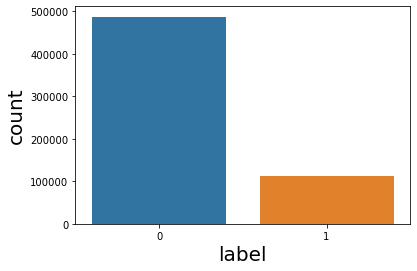

In [3]:
# visualize the distribution of labels
b = sns.countplot(x='target', data=df)
b.set_xlabel('label', fontsize=20)
b.set_ylabel('count', fontsize=20)

The target is skewed, hence use AUC as the evaluation metric.

In [4]:
df.ord_2.value_counts()

Freezing       142726
Warm           124239
Cold            97822
Boiling Hot     84790
Hot             67508
Lava Hot        64840
Name: ord_2, dtype: int64

In [5]:
# for ordinal variables
#mapping = {"Freezing": 0, 
#           "Warm": 1, 
#           "Cold": 2, 
#           "Boiling Hot": 3, 
#           "Hot": 4,
#           "Lava Hot": 5
#}
#df.loc[:, "ord_2"] = df.ord_2.map(mapping)

In [9]:
# xgb with label encoding
def run(fold):
    features = [f for f in df.columns if f not in ('id','target','kfold')]
    
    # fill all NaN values with 'NONE'
    for feature in features:
        df.loc[:, feature] = df[feature].astype(str).fillna('NONE')
    
    # label encode the features
    for col in features:
        # initialize LabelEncoder for each feature column
        lbl = preprocessing.LabelEncoder()
        # fit label encoder on all data
        lbl.fit(df[col])
        # transform all the data
        df.loc[:, col] = lbl.transform(df[col])
        
    df_train = df[df.kfold != fold].reset_index(drop=True) 
    df_valid = df[df.kfold == fold].reset_index(drop=True) 
    x_train = df_train[features].values
    x_valid = df_valid[features].values
    
    # initialize xgb model
    model = xgb.XGBClassifier(max_depth=7, n_estimators=200)
    
    # fit model on training data (ohe)
    model.fit(x_train, df_train.target.values)

    # predict on validation data
    # we need the probability values as we are calculating AUC 
    # we will use the probability of 1s
    valid_preds = model.predict_proba(x_valid)[:, 1]
    
    # get roc auc score
    auc = metrics.roc_auc_score(df_valid.target.values, valid_preds)
    
    # print auc
    print(f"Fold = {fold}, AUC = {auc}")

In [10]:
for fold_ in range(5):
    run(fold_)

Fold = 0, AUC = 0.7617090984573569
Fold = 1, AUC = 0.7602548852332586
Fold = 2, AUC = 0.761222848535793
Fold = 3, AUC = 0.7608917754999943
Fold = 4, AUC = 0.7606744739922326
